## Predicting laptop prices

In [137]:
import pandas as pd
import numpy as np

### 1. Get data

In [162]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv")

### 2. Preparing the dataset

In [163]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


#### Normalizing the column names

In [164]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [165]:
df.head(2)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


In [166]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [167]:
columns = ['ram', 'storage', 'screen', 'final_price']

df = df[columns]

In [168]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### 3. Exploratory Data Analysis

#### final_price distribution

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

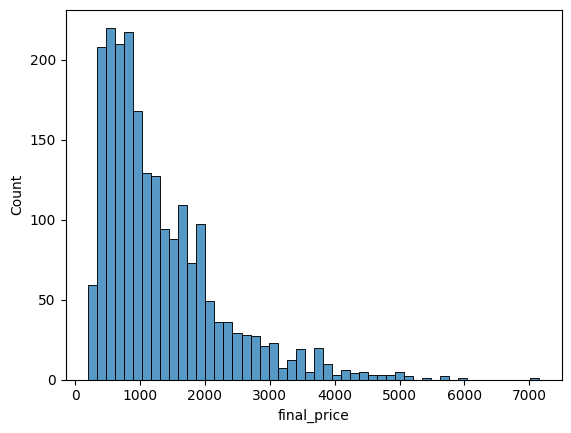

In [170]:
sns.histplot(df.final_price, bins=50)

##### Observation: The final_price variable does have a long tail

#### Columns with missing values

In [171]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

#### Median (50th percentile) value for variable `ram`

In [172]:
df['ram'].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

### 4. Dataset preparation and splitting (and shuffling) into `training`, `validation`, and `test` subsets with `60%/20%/20%` distribution

In [173]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [174]:
n_val, n_test, n_train

(432, 432, 1296)

In [150]:
idx = np.arange(n)

In [175]:
np.random.seed(42)
np.random.shuffle(idx)

In [176]:
df_shuffled = df.iloc[idx]

In [177]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [178]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [179]:
df_train

,ram,storage,screen,final_price
0,16,1000,16.0,1471.61
1,8,512,15.6,1349.00
2,4,256,14.0,398.01
3,8,512,17.3,729.00
4,16,1000,17.3,3899.99
...,...,...,...,...
1291,8,512,15.0,1649.00
1292,16,512,15.6,997.79
1293,8,512,14.0,979.00
1294,8,512,14.0,1474.28


In [180]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [181]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

### 5. Training a linear regression model

In [182]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

#### Training a model by filling the missing values in `screen` with its mean value and zero to determine the approach with better `RMSE`

##### with mean:

In [183]:
mean = df_train.ram.mean()

X_train = prepare_X(df_train, fillna_value=mean)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=mean)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(566.2853986644393)

##### with 0:

In [184]:
X_train = prepare_X(df_train, fillna_value=0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(564.1420209549518)

##### Observation: the RMSE value with zero replacement of null values is better.

### 6. Training a regularized linear regression

In [185]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

##### Trying different values of r `[0, 0.01, 0.1, 1, 5, 10, 100]` and Using RMSE to evaluate the model on the validation dataset.

In [186]:
for r in [0, 0.01, 1, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    print('%06s %0.2f' % (r, rmse_val))

     0 564.14
  0.01 564.15
     1 564.49
    10 566.56
   100 569.20


##### Observation: `r = 0`

### 7. Standard deviation of RMSE

In [187]:
rmses = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:        #setting the seed for which to evaluate the model on the validation dataset

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)        #splitting the dataset into validation (20%), test (20%) and training datasets (60%)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()              #shuffling the dataset

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)      #resetting indices
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values           #setting the training datasets     
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']                    #deleting the old columns to avoid being used in error

    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)      #training the model without regularization, filling the missing values with 0

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)                         #evaluating the model on the validation dataset

    result = rmse(y_val, y_pred)
    print(s, result)                    #computing the rmse for each seed value
    
    rmses.append(result)        #filling the empty rmse list with a pair of seed value and its corresponding rmse

0 565.4520868771027
1 636.7985423056726
2 588.9558697907962
3 597.8148920012521
4 571.962791511102
5 573.2383256618949
6 647.3438328407208
7 550.4398184485952
8 587.333503616991
9 576.1017929433108


In [190]:
SD_rmse = float(np.std(rmses)) #computing the standard deviation
SD_rmse

29.17649125829274

#### Using `seed` 9, combining `training` and `validation` datasets, filling the NaNs with 0 and training a model with `r=0.001` and finding `RMSE`

In [191]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)      #joinig both datasets

X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)  #training the model

X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)     #using the model on the test dataset

result = rmse(y_test, y_pred)
print(result)

608.609982204956
